In [9]:
import geopandas as gpd
import pandas as pd

from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import robust_scale

Clustering can help us group data points that are similar in certain features together, but what if you have geo data, or data where there are certain constraints on which cluster each data point go to?

This notebook discusses how regionalisation when used together with clustering can help make better sense

(borrowed from https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html)

In [18]:
# download data
# ! mkdir --parents geo/data && cd geo/data && wget https://geographicdata.science/book/_downloads/f2341ee89163afe06b42fc5d5ed38060/sandiego_tracts.gpkg

**data**

This is a dataset of SAn diego Census tracts (similar to LSOAs in the UK)--each row is one tract/area with summarised data about the people living in that tract

In [5]:
db = gpd.read_file("geo/data/sandiego_tracts.gpkg")

In [7]:
db.head(2).T

,0,1
GEOID,06073018300,06073018601
median_age,37.1,41.2
total_pop,2590.0,5147.0
total_pop_white,2375.0,4069.0
tt_work,1299.0,1970.0
hh_total,2590.0,5147.0
hh_female,137.0,562.0
total_bachelor,0.0,24.0
median_hh_income,62500.0,88165.0
income_gini,0.5355,0.4265


note the 'geometry' column above-- this lets us do the geospatial clustering (and plot data on a map, and other geo things)

**the analysis**

Assuming you want to cluster similar areas together, e.g for some sort of town planning, you can cluster solely by features (age, house value etc), or add in region into the mix. (since areas next to each other are more likely to be similar than areas on the other side of town)

In [10]:
cluster_variables = [
    "median_house_value",  # Median house value
    "pct_white",  # % tract population that is white
    "pct_rented",  # % households that are rented
    "pct_hh_female",  # % female-led households
    "pct_bachelor",  # % tract population with a Bachelors degree
    "median_no_rooms",  # Median n. of rooms in the tract's households
    "income_gini",  # Gini index measuring tract wealth inequality
    "median_age",  # Median age of tract population
    "tt_work",  # Travel time to work
]

db_scaled = robust_scale(db[cluster_variables])

**aggolmerative clustering (no geo constraint)**

In [12]:
np.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage="ward", n_clusters=5)
# Run clustering
model.fit(db_scaled)
# Assign labels to main data table
db["ward5"] = model.labels_

In [13]:
ward5means = db.groupby("ward5")[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
median_house_value,365932.350,625607.090,1202087.604,503608.711,503905.198
pct_white,0.589,0.598,0.871,0.770,0.766
pct_rented,0.573,0.360,0.285,0.287,0.657
pct_hh_female,0.105,0.098,0.107,0.112,0.076
pct_bachelor,0.023,0.006,0.002,0.009,0.006
median_no_rooms,4.566,5.860,6.010,5.738,3.904
income_gini,0.405,0.394,0.480,0.394,0.442
median_age,31.955,34.250,45.196,40.695,33.540
tt_work,2181.970,9260.400,1766.354,2268.718,2402.671


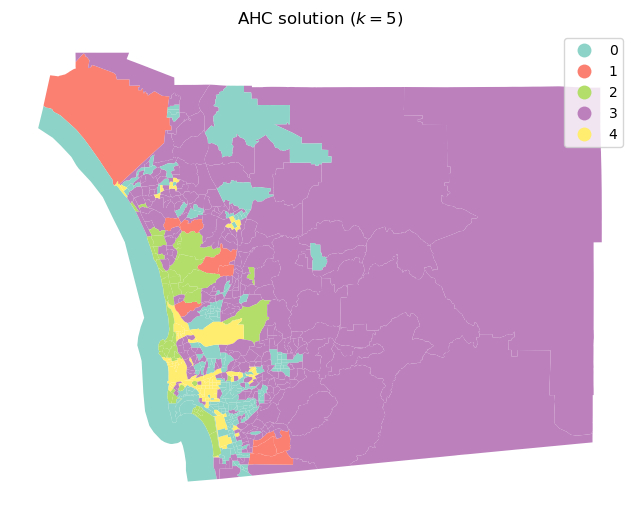

In [16]:
f, axs = plt.subplots(1, 1, figsize=(8, 8))


# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="ward5",
    categorical=True,
    cmap="Set3",
    legend=True,
    linewidth=0,
    ax=axs,
)
# Remove axis
axs.set_axis_off()
# Add title
axs.set_title("AHC solution ($k=5$)")

# Display the map
plt.show()

**clustering with geo constraint**

You can see that the areas are a lot more coherent by using the constraint

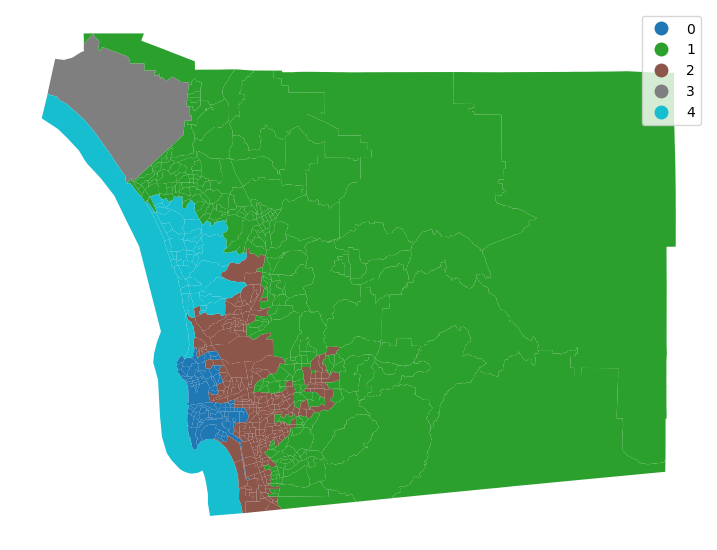

In [17]:
w = KNN.from_dataframe(db, k=4)
model2 = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model2.fit(db_scaled)

db["ward5wknn"] = model2.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth
# including a legend and with no boundary lines
db.plot(
    column="ward5wknn",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()